In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
sns.set_context('paper', font_scale=0.65)
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})
import matplotlib.pyplot as plt
from scipy import stats
import datasets
from tqdm.notebook import tqdm
from functools import lru_cache


import utils

In [2]:
train_ds, valid_ds, test_ds = utils.load_dataset()

Found cached dataset parquet (/home/johnny/.cache/huggingface/datasets/parquet/civil_comments-e92c9358c47debf9/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/johnny/.cache/huggingface/datasets/parquet/civil_comments-e92c9358c47debf9/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-26324163aea91a3b.arrow
Loading cached processed dataset at /home/johnny/.cache/huggingface/datasets/parquet/civil_comments-e92c9358c47debf9/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-392dd59de6b13b83.arrow
Loading cached processed dataset at /home/johnny/.cache/huggingface/datasets/parquet/civil_comments-e92c9358c47debf9/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-2bef193312149c10.arrow


In [3]:
score_npy = 'scores/roberta_balanced.npy'
score_column = 'scores'

# bins = None
# cut = 'quantile'
# allocation = 'optimal'
within = 0.2

In [4]:
labels = test_ds['toxicity']
scores = np.load(score_npy)
df = pd.DataFrame(data={'toxicity' : labels, 'toxic' : test_ds['label'], 'scores' : scores})

In [5]:
df.head(1)

,toxicity,toxic,scores
0,0.4,0,0.27451


In [6]:
df['toxic'].sum(), df['toxic'].mean()

(100601, 0.059007879761202295)

In [7]:
size = 12192

In [8]:
p = df['toxic'].mean()
random_sampling_var = p * (1 - p)
np.sqrt(random_sampling_var / size)

0.0021340791433234136

### Oracle bin search

In [9]:
def get_error(df):
    sizes_sigmas = []
    for i, group in df.groupby('bin'):
        # to round up to 1
        pilot = group['toxic']
        sizes_sigmas.append((len(group), np.std(pilot)))

    allocations = []
    denominator = np.sum([ n_h * sigma_h for n_h, sigma_h in sizes_sigmas ])
    for n_h, sigma_h in sizes_sigmas:
        n_from_bin = size * n_h * sigma_h / denominator
        allocations.append(n_from_bin)
    
    stratified_var = 0
    for (i, group), n_from_bin in zip(df.groupby('bin'), allocations):

        p = group['toxic'].mean()

        # approximation when the groups are very large
        stratified_var += np.square(len(group) / len(df)) * (group['toxic'].var() / n_from_bin)
    return np.sqrt(stratified_var)

In [10]:
'''
=== 2 ===
- [0, 1]
1 [0, 2, 1]

=== 4 ===
1 [0, 3, 2, 1]
3 [0, 3, 2, 4, 1]

=== 8 ===
1 [0, 5, 3, 2, 4, 1]
3 [0, 5, 3, 6, 2, 4, 1]

5 [0, 5, 6, 3, 2, 7, 4, 1]
7 [0, 5, 6, 3, 2, 7, 4, 8, 1]

=== 16 ===
1 [0, 9, 5, 6, 3, 2, 7, 4, 8, 1]
3 [0, 9, 5, 10, 6, 3, 2, 7, 4, 8, 1]
5 [0, 9, 5, 10, 6, 11, 3, 2, 7, 4, 8, 1]
7 [0, 9, 5, 10, 6, 11, 3, 12, 2, 7, 4, 8, 1]

9  [0, 9, 5, 10, 6, 11, 3, 12, 2, 13, 7, 4, 8, 1]
11 [0, 9, 5, 10, 6, 11, 3, 12, 2, 13, 7, 14, 4, 8, 1]
13 [0, 9, 5, 10, 6, 11, 3, 12, 2, 13, 7, 14, 4, 15, 8, 1]
15 [0, 9, 5, 10, 6, 11, 3, 12, 2, 13, 7, 14, 4, 15, 8, 16, 1]
'''

'\n=== 2 ===\n- [0, 1]\n1 [0, 2, 1]\n\n=== 4 ===\n1 [0, 3, 2, 1]\n3 [0, 3, 2, 4, 1]\n\n=== 8 ===\n1 [0, 5, 3, 2, 4, 1]\n3 [0, 5, 3, 6, 2, 4, 1]\n\n5 [0, 5, 6, 3, 2, 7, 4, 1]\n7 [0, 5, 6, 3, 2, 7, 4, 8, 1]\n\n=== 16 ===\n1 [0, 9, 5, 6, 3, 2, 7, 4, 8, 1]\n3 [0, 9, 5, 10, 6, 3, 2, 7, 4, 8, 1]\n5 [0, 9, 5, 10, 6, 11, 3, 2, 7, 4, 8, 1]\n7 [0, 9, 5, 10, 6, 11, 3, 12, 2, 7, 4, 8, 1]\n\n9  [0, 9, 5, 10, 6, 11, 3, 12, 2, 13, 7, 4, 8, 1]\n11 [0, 9, 5, 10, 6, 11, 3, 12, 2, 13, 7, 14, 4, 8, 1]\n13 [0, 9, 5, 10, 6, 11, 3, 12, 2, 13, 7, 14, 4, 15, 8, 1]\n15 [0, 9, 5, 10, 6, 11, 3, 12, 2, 13, 7, 14, 4, 15, 8, 16, 1]\n'

In [11]:
def oracle_bins(df, depth=4):
    minimum_bins = [0, 1]
    minimum_err = 1
    steps = 10

    for level in range(1, depth+1):
        if level == 1:
            indexes = [1]
        else:
            indexes = list(range(1, level*2, 2))

        for idx in indexes:
            bins = minimum_bins.copy()
            bins.insert(idx, 0)
            lb, ub = bins[idx-1], bins[idx+1]

            # print(lb + (ub-lb)/steps, ub)

            for i in np.linspace( lb + (ub-lb)/steps, ub, steps, endpoint=False):
                bins[idx] = i
                df['bin'] = pd.qcut(df[score_column], bins)
                new_err = get_error(df)
                if new_err < minimum_err:
                    minimum_err = new_err
                    minimum_bins = bins.copy()

    return minimum_bins

### Allocation

In [12]:
np.log(3) / np.log(2)

1.5849625007211563

In [26]:
def calculate(cut = 'quantile', allocation = 'optimal', within = 0.2, pilot_size=50):
    print(cut, end=',')
    print(allocation, end=',')
    
    results = []
    
    for bins in range(2, 18, 2):
        if cut == 'eqwidth':
            minimum, maximum = df[score_column].min(), df[score_column].max()
            df['bin'] = pd.cut(df[score_column], np.linspace(minimum, maximum, num=bins+1), include_lowest=True)
        elif cut == 'quantile':
            df['bin'] = pd.qcut(df[score_column], np.linspace(0, 1, num=bins+1))
        elif cut == 'searched':
            depth = int(np.log(bins) / np.log(2))
            bins = oracle_bins(df, depth = depth)
            df['bin'] = pd.qcut(df[score_column], bins)

        sizes_sigmas = []
        for i, group in df.groupby('bin'):
            # to round up to 1
            if allocation == 'pilot':
                pilot = np.array(group['toxic'].sample(pilot_size + 2))
                pilot[-1] = 1
                pilot[-2] = 0
            elif allocation == 'optimal':
                pilot = group['toxic']
            else:
                pilot = group['toxic']
            sizes_sigmas.append((len(group), np.std(pilot)))

        if allocation == 'equal':
            sizes_sigmas = [ (1, 1) for i, j in sizes_sigmas ]

        multipliers = []
        denominator = np.sum([ n_h * sigma_h for n_h, sigma_h in sizes_sigmas ])
        for n_h, sigma_h in sizes_sigmas:
            n_from_bin = n_h * sigma_h / denominator
            multipliers.append(n_from_bin)

        desired_ci = p * within

        alpha = 0.05
        z_statistic = stats.norm.ppf(1 - (alpha / 2))
        desired_var = np.square(desired_ci / z_statistic)

        numerator = 0
        for (i, group), multip_h in zip(df.groupby('bin'), multipliers):
            # approximation when the groups are very large
            numerator += np.square(len(group) / len(df)) * (group['toxic'].var() / multip_h)

        minimum = numerator / desired_var
        
        if allocation == 'pilot':
            n = np.sum([max(minimum * multip, pilot_size) for multip in multipliers])
        else:
            n = np.sum([minimum * multip for multip in multipliers])
        print(int(n+1), end=',')
        results.append(int(n+1))
    print()
    return results

In [27]:
bins = oracle_bins(df, depth = int(2 / 2))
df['bin'] = pd.qcut(df[score_column], bins)
get_error(df)

0.0012726332999243315

In [28]:
df['bin'] = pd.cut(df['scores'], np.linspace(0, 1, num=2+1), include_lowest=True)
get_error(df)

0.0012722946490513034

In [29]:
def calculate_many(binning, alloc, within, pilot_size=50, trials=30):
    results = []
    for i in range(0, trials):
        results.append(calculate(binning, alloc, within, pilot_size=pilot_size))
    results = np.array(results)
    results = np.mean(results, axis=0)
    return results

In [30]:
results1 = calculate('searched', 'optimal', 0.2)
results2 = calculate('eqwidth', 'optimal', 0.2)
results3 = calculate('quantile', 'optimal', 0.2)

results4 = calculate('quantile', 'optimal', 0.2)
results5 = calculate_many('quantile', 'pilot', 0.2, pilot_size=50)
results6 = calculate('quantile', 'equal', 0.2)

results7 = calculate('quantile', 'optimal', 0.2)
results8 = calculate_many('quantile', 'pilot', 0.2, pilot_size=10)
results9 = calculate_many('quantile', 'pilot', 0.2, pilot_size=50)
results10 = calculate_many('quantile', 'pilot', 0.2, pilot_size=100)

searched,optimal,545,380,380,352,352,352,352,347,
eqwidth,optimal,545,505,488,477,469,462,457,453,
quantile,optimal,833,518,430,394,373,360,352,346,
quantile,optimal,833,518,430,394,373,360,352,346,
quantile,pilot,1018,698,593,552,613,681,765,840,
quantile,pilot,1018,716,621,562,614,675,754,848,
quantile,pilot,1037,700,573,572,622,675,761,830,
quantile,pilot,981,728,595,552,616,682,768,837,
quantile,pilot,973,657,588,551,622,681,756,845,
quantile,pilot,1018,691,570,560,673,689,779,844,
quantile,pilot,981,682,578,551,616,688,753,844,
quantile,pilot,1037,670,617,567,625,683,762,832,
quantile,pilot,1062,647,588,566,609,677,760,849,
quantile,pilot,1096,707,593,555,615,693,764,836,
quantile,pilot,1062,670,581,580,625,685,768,834,
quantile,pilot,1148,665,584,566,608,678,766,837,
quantile,pilot,991,690,602,555,609,680,760,838,
quantile,pilot,1096,744,590,555,611,681,759,849,
quantile,pilot,1037,742,589,575,607,672,754,842,
quantile,pilot,1018,682,585,608,610,683,751,841,
quantile,pilot,1018,6

binning,allocation,2,4,6,8,10,12,14,16
binning,allocation,2,4,6,8,10,12,14,16
binning,allocation,2,4,6,8,10,12,14,16


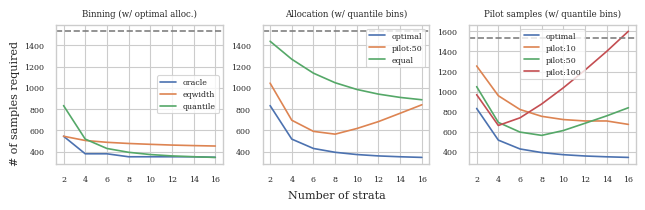

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(6.29,1.8), sharey=False)
fig.tight_layout()

# plot 1

print('binning,allocation,%s' % ','.join([ str(i) for i in range(2,18,2) ]))
ax[0].set_title('Binning (w/ optimal alloc.)')

sns.lineplot(x=list(range(2,18,2)), y=results1, ax=ax[0], label='oracle')
sns.lineplot(x=list(range(2,18,2)), y=results2, ax=ax[0], label='eqwidth')
sns.lineplot(x=list(range(2,18,2)), y=results3, ax=ax[0], label='quantile')

print('binning,allocation,%s' % ','.join([ str(i) for i in range(2,18,2) ]))
ax[1].set_title('Allocation (w/ quantile bins)')

sns.lineplot(x=list(range(2,18,2)), y=results4, ax=ax[1], label='optimal')
sns.lineplot(x=list(range(2,18,2)), y=results5, ax=ax[1], label='pilot:50')
sns.lineplot(x=list(range(2,18,2)), y=results6, ax=ax[1], label='equal')


print('binning,allocation,%s' % ','.join([ str(i) for i in range(2,18,2) ]))
ax[2].set_title('Pilot samples (w/ quantile bins)')

sns.lineplot(x=list(range(2,18,2)), y=results7, ax=ax[2], label='optimal')
sns.lineplot(x=list(range(2,18,2)), y=results8, ax=ax[2], label='pilot:10')
sns.lineplot(x=list(range(2,18,2)), y=results9, ax=ax[2], label='pilot:50')
sns.lineplot(x=list(range(2,18,2)), y=results10, ax=ax[2], label='pilot:100')


ax[0].axhline(1532, linestyle='--', color='gray')
ax[1].axhline(1532, linestyle='--', color='gray')
ax[2].axhline(1532, linestyle='--', color='gray')
ax[0].set_xticks(range(2,17,2))
ax[1].set_xticks(range(2,17,2))
ax[2].set_xticks(range(2,17,2))


fig.text(0.5, -0.03, 'Number of strata', ha='center', size=8)
fig.text(-0.02, 0.5, '# of samples required', va='center', rotation='vertical', size=8)
plt.savefig('civilcomments_binning_allocation.pdf', bbox_inches='tight')